<a href="https://colab.research.google.com/github/maduprey/DelayExplore/blob/master/deep_learning_protein_topology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Protein Topology


What is being done in the [Frontiers](https://www.frontiersin.org/articles/10.3389/frai.2021.681174/full) paper is building several binary classifiers -- 55 to be exact -- in which each predicts whether all the proteins are either, for example, a.3.1 or not.

Improvements to MLP accuracy
*   Increased `n_perm`, the number of points to subsample, to 1,000, for 5% gain, 40% total; Increased to 2,000 and saw decrease (surprisingly). Now using 1,300 (about median) seems decent, but not sure if better/worse
*   Using only $H_1$ and $H_2$ increased by about 2.5% to a point, and then overfit
*   Increased the number of epochs from 800 to 1,000 resulted in increased accuracy without much overfitting: 42% total
*   A learning rate (Adam opt) of 0.001 seems to hit the sweet spot (tried 0.01 and 0.001 with suboptimal results)
*   No meaningful difference between NAdam and Adam optimizers
*   Changed persistence parameters `thresh`, `globalmaxdeath`, `meshstop` from 10 to 20, didn't see any improvement



In [26]:
!pip install -q git+https://github.com/azlawson/PersistenceCurves.git
!pip install -q biopython
!pip install -q py3Dmol
!pip install -q scikit-tda

In [27]:
import os
import numpy as np
import persistencecurves as pc
import matplotlib.pyplot as plt
import tensorflow as tf
import py3Dmol
import random

from xgboost import XGBClassifier # Might not need
from lightgbm import LGBMClassifier # Might not need
from Bio.PDB import PDBParser
from ripser import ripser
from persim import plot_diagrams
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [28]:
parser = PDBParser(PERMISSIVE=1, QUIET=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/data')

## Exploratory analysis
Let's look at the number of coordinates to determine how we might want to set Ripster's [n_perm](https://ripser.scikit-tda.org/en/latest/reference/stubs/ripser.ripser.html#ripser.ripser) parameter which controls the number of points to subsample

In [ ]:
# Inspect the number of coordinates
n_atoms = np.empty((0, 1), int)
for file in os.listdir("./SCOP40mini"):
    structure_id = os.path.splitext(file)[0]
    structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
    
    # Generate a list of its atoms' coordinates in R^3
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)

    n_atoms = np.append(n_atoms, len(coords))

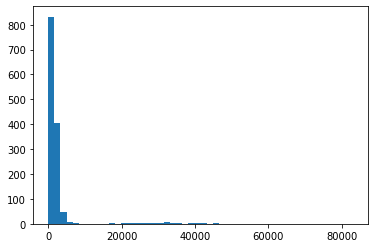

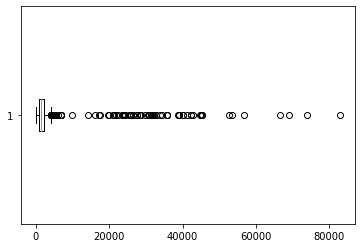

1379.0
3071.304347826087


In [ ]:
# Histogram
plt.hist(n_atoms, bins=50)
plt.show()

# Boxplot omitting outliers
plt.boxplot(n_atoms, showfliers=False, vert=0)
plt.show()

print(np.median(n_atoms))
print(np.mean(n_atoms))

## Generate persistence diagrams
This loop is rather time-intensive. We can alternatively load saved diagrams below

In [ ]:
# diagrams = np.empty((0, 200), int) # Use if computing only H_0, H_1
diagrams = np.empty((0, 300), int) # Use if computing H_0, H_1, and H_2
classes_fold = np.empty((0, 1), str)
classes_superfamily = np.empty((0, 1), str)
classes_family = np.empty((0, 1), str)

for file in os.listdir("./SCOP40mini"):
    structure_id = os.path.splitext(file)[0]
    structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
    
    # We grab the SCOP sccs to build the classes
    sccs = parser.get_header()['astral']['SCOP-sccs']
    fold = sccs.rsplit('.', 2)[0]
    superfamily = sccs.rsplit('.', 1)[0]
    family = sccs
    
    # Generate a list of its atoms' coordinates in R^3
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)
    
    # Compute persistent homology
    # We roughly use the median number of atoms to set the subsampling threshold 
    if len(coords) > 1300:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False, n_perm=1300)['dgms']
    else:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False)['dgms']

    # Generate persistence curves from diagrams
    # TODO: does remove vs replace make big impact?
    d_h0 = pc.Diagram(Dgm=diagram[0], globalmaxdeath=10, inf_policy='remove')
    d_h1 = pc.Diagram(Dgm=diagram[1], globalmaxdeath=10, inf_policy='remove')
    d_h2 = pc.Diagram(Dgm=diagram[2], globalmaxdeath=10, inf_policy='remove')

    # Generate life curves
    # TODO: investigate different types of curves, different resolutions
    # trying fewer in mesh
    lc_h0 = d_h0.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h1 = d_h1.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h2 = d_h2.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)

    # Join life curves together
    lc_all = np.concatenate((lc_h0, lc_h1, lc_h2))
    
    diagrams = np.vstack((diagrams, lc_all))
    classes_fold = np.vstack((classes_fold, fold))
    classes_superfamily = np.vstack((classes_superfamily, superfamily))
    classes_family = np.vstack((classes_family, family))

    print(diagrams.shape)

(1, 300)
(2, 300)
(3, 300)
(4, 300)
(5, 300)
(6, 300)
(7, 300)
(8, 300)
(9, 300)
(10, 300)
(11, 300)
(12, 300)
(13, 300)
(14, 300)
(15, 300)
(16, 300)
(17, 300)
(18, 300)
(19, 300)
(20, 300)
(21, 300)
(22, 300)
(23, 300)
(24, 300)
(25, 300)
(26, 300)
(27, 300)
(28, 300)
(29, 300)
(30, 300)
(31, 300)
(32, 300)
(33, 300)
(34, 300)
(35, 300)
(36, 300)
(37, 300)
(38, 300)
(39, 300)
(40, 300)
(41, 300)
(42, 300)
(43, 300)
(44, 300)
(45, 300)
(46, 300)
(47, 300)
(48, 300)
(49, 300)
(50, 300)
(51, 300)
(52, 300)
(53, 300)
(54, 300)
(55, 300)
(56, 300)
(57, 300)
(58, 300)
(59, 300)
(60, 300)
(61, 300)
(62, 300)
(63, 300)
(64, 300)
(65, 300)
(66, 300)
(67, 300)
(68, 300)
(69, 300)
(70, 300)
(71, 300)
(72, 300)
(73, 300)
(74, 300)
(75, 300)
(76, 300)
(77, 300)
(78, 300)
(79, 300)
(80, 300)
(81, 300)
(82, 300)
(83, 300)
(84, 300)
(85, 300)
(86, 300)
(87, 300)
(88, 300)
(89, 300)
(90, 300)
(91, 300)
(92, 300)
(93, 300)
(94, 300)
(95, 300)
(96, 300)
(97, 300)
(98, 300)
(99, 300)
(100, 300)
(101, 30

In [ ]:
np.save('./diagrams', diagrams)
np.save('./classes_fold', classes_fold)
np.save('./classes_superfamily', classes_superfamily)
np.save('./classes_family', classes_family)

Set desired SCOP domain classification (e.g., superfamily)

In [ ]:
classes = classes_superfamily

## Load diagrams and classes

In [30]:
diagrams = np.load('./diagrams.npy')
classes = np.load('./classes_superfamily.npy')

## Data preprocessing
Run either **A** or **B**

**A**: Prep data for SVM and gradient boosting models

In [ ]:
# Generate binary targets for an arbitrary class 
# targets = np.ravel(label_binarize(classes, classes=['a.3.1'])) # If binary
targets = np.ravel(classes) # If multiclass
data = diagrams

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2)

**B**: Prep data for TensorFlow

In [31]:
# Count the number of unique classes
num_classes = len(np.unique(classes))
print(num_classes)

# Prepare targets and data for TensorFlow
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(classes)
targets = one_hot_encoder.transform(classes)
data = diagrams

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2)

24


## Build SVM and gradient boosting models

In [ ]:
clf = SVC(kernel='rbf', C=20, random_state=42)

# Perform 5-fold cross validation
scores = cross_val_score(clf, data, targets, cv=5)
print('%0.3f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))

# Test accuracy using testing data
# clf = SVC(kernel='rbf', C=20).fit(train_data, train_targets)
#print('Train Accuracy: {acc:0.3f}'.format(acc=clf.score(train_data, train_targets)))
#print('Test Accuracy: {acc:0.3f}'.format(acc=clf.score(test_data, test_targets)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.127 accuracy with a standard deviation of 0.02


In [ ]:
clf = XGBClassifier()

# Perform 5-fold cross validation
scores = cross_val_score(clf, data, targets, cv=5)
print('%0.3f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.208 accuracy with a standard deviation of 0.03


In [ ]:
clf = LGBMClassifier()

# Perform 5-fold cross validation
scores = cross_val_score(clf, data, targets, cv=5)
print('%0.3f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))

# Test accuracy using testing data
# clf = LGBMClassifier().fit(train_data, train_targets)
# print('Train Accuracy: {acc:0.3f}'.format(acc=clf.score(train_data, train_targets)))
# print('Test Accuracy: {acc:0.3f}'.format(acc=clf.score(test_data, test_targets)))

## Build MLP models

In [7]:
def get_test_accuracy(model, test_data, test_targets):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=test_data, y=test_targets, verbose=0)
    print('Test Accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
# Delete model if it exists
if 'model' in globals():
    del model

### Binary classifier

In [ ]:
# Build binary sequential model for superfamily
k_initializer = tf.keras.initializers.he_uniform()
b_initializer = tf.keras.initializers.Ones()

dropout_rate = 0.10

model = Sequential([
    Dense(200, activation = 'relu', 
            input_shape = train_data[0].shape, 
            kernel_initializer=k_initializer,
            bias_initializer=b_initializer),
    Dropout(dropout_rate),
    Dense(200, activation = 'relu'),
    Dense(200, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(1, activation='sigmoid')
    ])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

# Fit model
history = model.fit(train_data, train_targets, 
                    epochs=200, validation_split=0.15, batch_size=50, 
                    verbose=1)


### Multiclass classifier (experimental)

In [32]:
# Build sequential model for superfamily
k_initializer = tf.keras.initializers.he_uniform()
b_initializer = tf.keras.initializers.Ones()

dropout_rate = 0.10

model = Sequential([
    Dense(200, activation = 'relu', 
            input_shape = train_data[0].shape, 
            kernel_initializer=k_initializer,
            bias_initializer=b_initializer),
    Dropout(dropout_rate),
    Dense(200, activation = 'relu'),
    Dense(200, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(num_classes, activation='softmax')
    ])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Fit model
history = model.fit(train_data, train_targets, 
                    epochs=1000, validation_split=0.15, batch_size=500, 
                    verbose=1)

Epoch 1/1000
2/2 [==============================] - 3s 223ms/step - loss: 355.3275 - acc: 0.0575 - val_loss: 174.8669 - val_acc: 0.0552
Epoch 2/1000
2/2 [==============================] - 0s 26ms/step - loss: 180.2624 - acc: 0.0597 - val_loss: 94.2198 - val_acc: 0.1166
Epoch 3/1000
2/2 [==============================] - 0s 25ms/step - loss: 123.8030 - acc: 0.0618 - val_loss: 53.8152 - val_acc: 0.1288
Epoch 4/1000
2/2 [==============================] - 0s 26ms/step - loss: 79.2529 - acc: 0.0933 - val_loss: 40.3505 - val_acc: 0.1656
Epoch 5/1000
2/2 [==============================] - 0s 28ms/step - loss: 61.5974 - acc: 0.0889 - val_loss: 33.7996 - val_acc: 0.1718
Epoch 6/1000
2/2 [==============================] - 0s 25ms/step - loss: 47.9694 - acc: 0.1030 - val_loss: 26.9310 - val_acc: 0.1350
Epoch 7/1000
2/2 [==============================] - 0s 26ms/step - loss: 40.5816 - acc: 0.0879 - val_loss: 20.6824 - val_acc: 0.0552
Epoch 8/1000
2/2 [==============================] - 0s 25ms/step

Let's explore what's going wrong in a mistaken classification

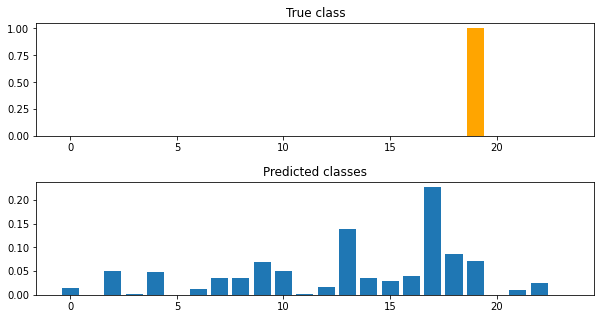

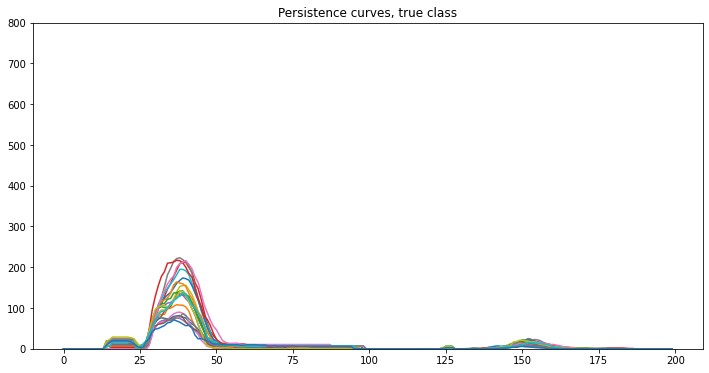

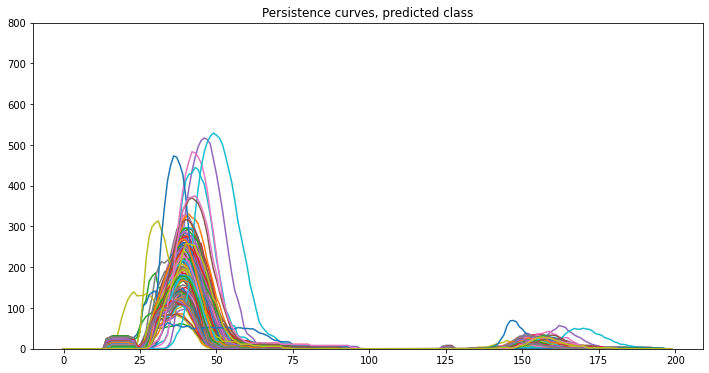

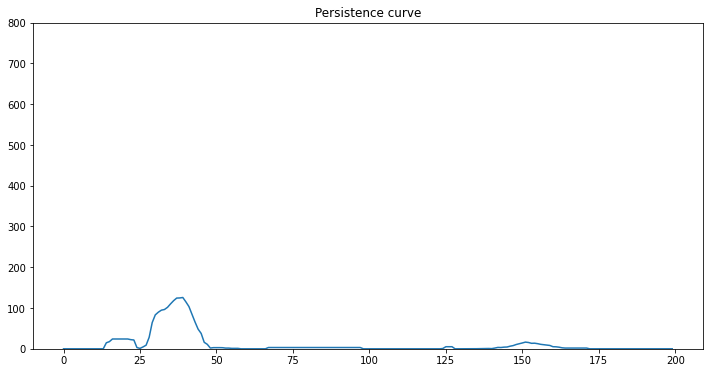

In [98]:
predictions = model.predict(test_data)

i = 16

true_class = test_targets[i]
pred_class = tf.one_hot(tf.argmax(predictions[i]), depth = num_classes).numpy()

true_class_profiles = []
for j in range(0, len(train_targets)):
    if(np.array_equal(train_targets[j], true_class) == True):
        true_class_profiles.append(j)

pred_class_profiles = []
for j in range(0, len(train_targets)):
    if(np.array_equal(train_targets[j], pred_class) == True):
        pred_class_profiles.append(j)  


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.4)
ax[0].bar(np.arange(num_classes), test_targets[i], color='orange')
ax[0].set_title('True class')
ax[1].bar(np.arange(num_classes), predictions[i])
ax[1].set_title('Predicted classes')
plt.show()

homology = range(100, 300)

# Plot all the persistence curves for a given class layered onto one another, or maybe the mean?
fig, ax = plt.subplots(figsize=(12, 6))
for k in true_class_profiles:
    ax.plot(train_data[k, homology])
    ax.set_title('Persistence curves, true class')
plt.ylim([0, 800])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
for k in pred_class_profiles:
    ax.plot(train_data[k, homology])
    ax.set_title('Persistence curves, predicted class')
plt.ylim([0, 800])
plt.show()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data[i, homology])
ax.set_title('Persistence curve')
plt.ylim([0, 800])
plt.show()


In [68]:
# view = py3Dmol.view(query='pdb:'+'1a9x', linked=True, viewergrid=(2,2))
# view.setViewStyle({'style':'outline','color':'black','width':0.1})
# view.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}},viewer=(0,1))
# view.setStyle({'stick':{'colorscheme':'greenCarbon'}},viewer=(1,0))
# view.setStyle({'cartoon':{'color':'spectrum'}},viewer=(1,1))

TODO: I don't think there's exactly alignment between the files and the mols
Maybe consider adding the mol to the "diagrams" file

In [105]:
# Get a random true class from PDB
rand_true_class = random.choice(true_class_profiles)

file = os.listdir("./SCOP40mini")[rand_true_class]
structure_id = os.path.splitext(file)[0]
structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
pdb_id_rand_true_class = parser.get_header()['astral']['Source-PDB']

rand_true_class_mol = py3Dmol.view(query='pdb:'+pdb_id_rand_true_class)
rand_true_class_mol.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [104]:
# Get a random predicted class from PDB
rand_pred_class = random.choice(pred_class_profiles)

file = os.listdir("./SCOP40mini")[rand_pred_class]
structure_id = os.path.splitext(file)[0]
structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
pdb_id_rand_pred_class = parser.get_header()['astral']['Source-PDB']

rand_pred_class_mol = py3Dmol.view(query='pdb:'+pdb_id_rand_pred_class)
rand_pred_class_mol.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [106]:
# Get the actual file of interest
file = os.listdir("./SCOP40mini")[i]
structure_id = os.path.splitext(file)[0]
structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
pdb_id = parser.get_header()['astral']['Source-PDB']

selected_mol = py3Dmol.view(query='pdb:'+pdb_id)
selected_mol.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
file = os.listdir("./SCOP40mini")[i]
structure_id = os.path.splitext(file)[0]
structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
pdb_id = parser.get_header()['astral']['Source-PDB']

view = py3Dmol.view(query='pdb:'+pdb_id)
view.setStyle({'cartoon':{'color':'spectrum'}})
view

### Multiclass classifier (stable)

The following model achieves about 42% acc without overfitting

In [ ]:
# Build sequential model for superfamily
k_initializer = tf.keras.initializers.he_uniform()
b_initializer = tf.keras.initializers.Ones()

dropout_rate = 0.10

model = Sequential([
    Dense(200, activation = 'relu', 
            input_shape = train_data[0].shape, 
            kernel_initializer=k_initializer,
            bias_initializer=b_initializer),
    Dropout(dropout_rate),
    Dense(200, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(200, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'),
    Dense(num_classes, activation='softmax')
    ])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Fit model
history = model.fit(train_data, train_targets, 
                    epochs=800, validation_split=0.15, batch_size=100, 
                    verbose=1)

Epoch 1/800
10/10 [==============================] - 1s 31ms/step - loss: 204.0123 - acc: 0.0770 - val_loss: 29.4518 - val_acc: 0.0613
Epoch 2/800
10/10 [==============================] - 0s 7ms/step - loss: 45.5439 - acc: 0.0781 - val_loss: 15.2686 - val_acc: 0.1472
Epoch 3/800
10/10 [==============================] - 0s 8ms/step - loss: 25.2997 - acc: 0.1030 - val_loss: 8.0702 - val_acc: 0.1534
Epoch 4/800
10/10 [==============================] - 0s 7ms/step - loss: 15.8617 - acc: 0.0911 - val_loss: 4.5176 - val_acc: 0.1963
Epoch 5/800
10/10 [==============================] - 0s 8ms/step - loss: 11.8458 - acc: 0.0748 - val_loss: 3.7957 - val_acc: 0.0798
Epoch 6/800
10/10 [==============================] - 0s 8ms/step - loss: 7.7563 - acc: 0.0835 - val_loss: 3.4106 - val_acc: 0.0491
Epoch 7/800
10/10 [==============================] - 0s 7ms/step - loss: 6.5472 - acc: 0.0716 - val_loss: 3.2556 - val_acc: 0.0798
Epoch 8/800
10/10 [==============================] - 0s 7ms/step - loss: 5

## Summarize model performance

In [ ]:
model.summary()
get_test_accuracy(model, test_data, test_targets)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

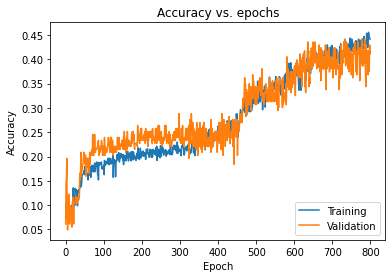

In [ ]:
plt.clf()
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Mapper Experimentation

In [ ]:
import sklearn
import kmapper as km

In [ ]:
file = os.listdir("./SCOP40mini")[10]

structure_id = os.path.splitext(file)[0]
structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)

# We grab the SCOP sccs to build the classes
sccs = parser.get_header()['astral']['SCOP-sccs']
fold = sccs.rsplit('.', 2)[0]
superfamily = sccs.rsplit('.', 1)[0]
family = sccs

# Generate a list of its atoms' coordinates in R^3
coords = []
for atom in structure.get_atoms():
    coords.append(list(atom.get_vector()))
coords = np.array(coords)

In [ ]:
mapper = km.KeplerMapper(verbose=2)
lens = mapper.fit_transform(coords)

graph = mapper.map(
    lens,
    coords,
    clusterer=sklearn.cluster.DBSCAN(eps=0.2, min_samples=1),
    cover=km.Cover(5, 0.7),
)

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (1253, 3)

..Projecting data using: sum

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (1253, 3) using lens shaped (1253, 1)

Minimal points in hypercube before clustering: 1
Creating 5 hypercubes.
   > Found 524 clusters in hypercube 0.
   > Found 808 clusters in hypercube 1.
   > Found 1078 clusters in hypercube 2.
   > Found 884 clusters in hypercube 3.
   > Found 540 clusters in hypercube 4.

Created 4159 edges and 3834 nodes in 0:00:04.936415.


In [ ]:
mapper.visualize(
    graph, path_html="atom.html", custom_tooltips=np.arange(len(lens))
)
km.drawing.draw_matplotlib(graph)
plt.show()

Wrote visualization to: atom.html
no display found. Using non-interactive Agg backend
